In [1]:
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
def calc_k(domain, scenario, pert, adj):

    if adj:
        if domain == "global":
            y_lat = 38
        elif domain == "nested":
            y_lat = 41.5
    else:
        y_lat = 42
    
    dir = "/n/home06/nbalasus/holyscratch01/jacobian"
    base_run = f"{dir}/{domain}/scenario-{scenario}/base/gc/OutputDir/"
    pert_run = f"{dir}/{domain}/scenario-{scenario}/pert-{pert}/gc/OutputDir/"

    with xr.open_dataset(f"{base_run}/GEOSChem.SpeciesConc.20180501_0000z.nc4") as spc, xr.open_dataset(f"{base_run}/GEOSChem.StateMet.20180501_0000z.nc4") as met, xr.open_dataset(f"{base_run}/HEMCO_diagnostics.201804010000.nc") as emi:
        mol_dry_air = (met["Met_AIRDEN"]*met["Met_AIRVOL"])/29e-3
        xch4 = 1e9*(spc["SpeciesConcVV_CH4"]*mol_dry_air).sum(dim="lev")/mol_dry_air.sum(dim="lev")
        y_base = xch4.sel(lat=y_lat, lon=-100).values[0]
        x_base = emi["EmisCH4_Total"].sel(lat=42, lon=-100).values[0]

    with xr.open_dataset(f"{pert_run}/GEOSChem.SpeciesConc.20180501_0000z.nc4") as spc, xr.open_dataset(f"{pert_run}/GEOSChem.StateMet.20180501_0000z.nc4") as met, xr.open_dataset(f"{pert_run}/HEMCO_diagnostics.201804010000.nc") as emi:
        mol_dry_air = (met["Met_AIRDEN"]*met["Met_AIRVOL"])/29e-3
        xch4 = 1e9*(spc["SpeciesConcVV_CH4"]*mol_dry_air).sum(dim="lev")/mol_dry_air.sum(dim="lev")
        y_pert = xch4.sel(lat=y_lat, lon=-100).values[0]
        x_pert = emi["EmisCH4_Total"].sel(lat=42, lon=-100).values[0]
        
    # print(f"({y_pert}-{y_base})/({x_pert}-{x_base})")
    # print(f"{(y_pert-y_base)/(x_pert-x_base)}")
    return (y_pert-y_base)/(x_pert-x_base)

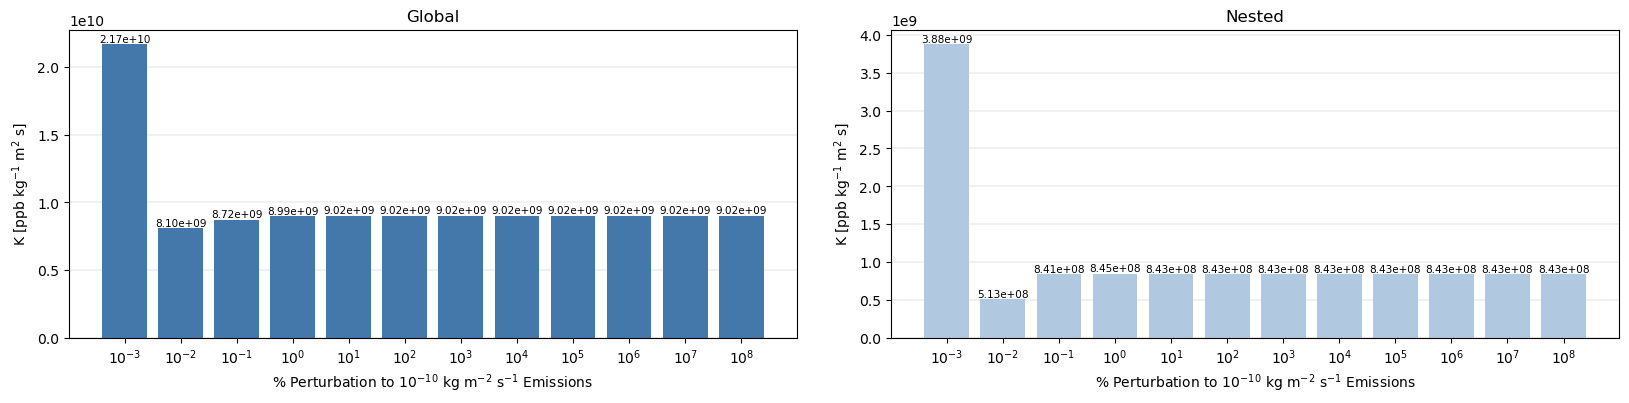

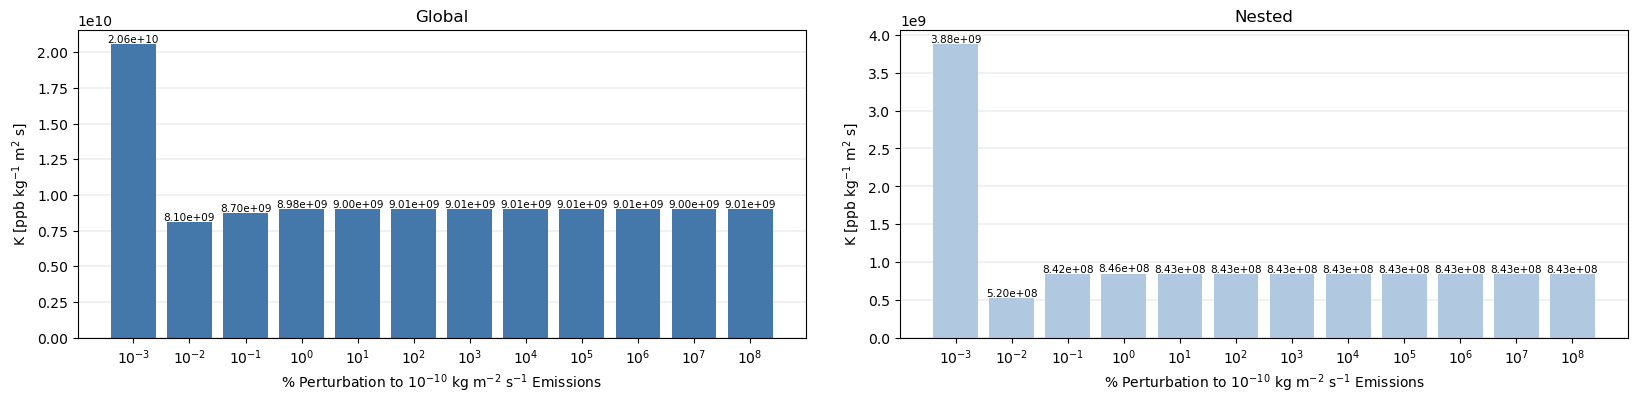

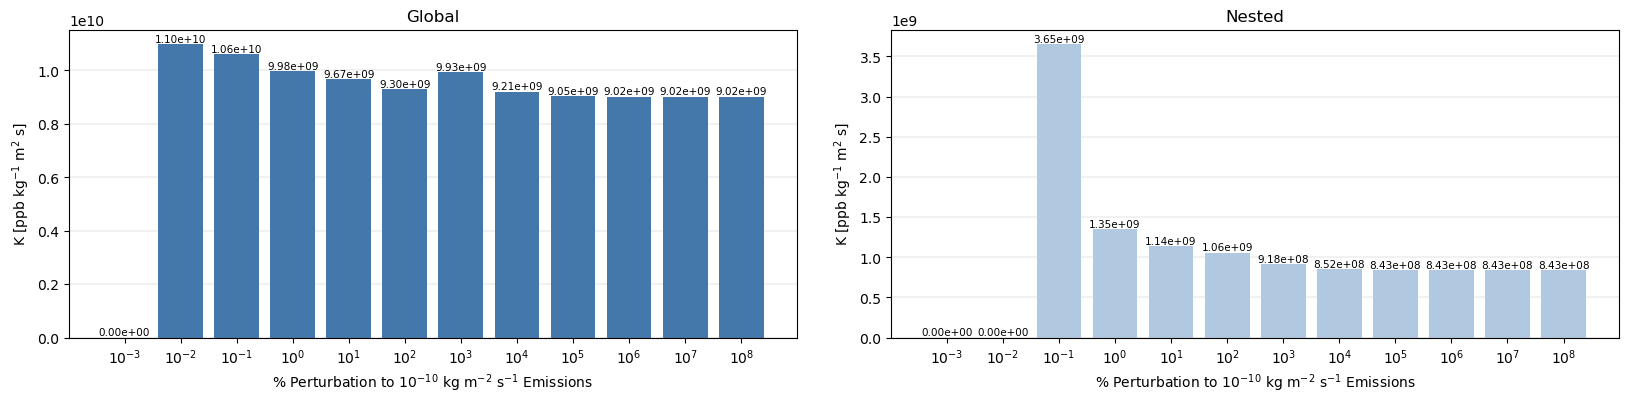

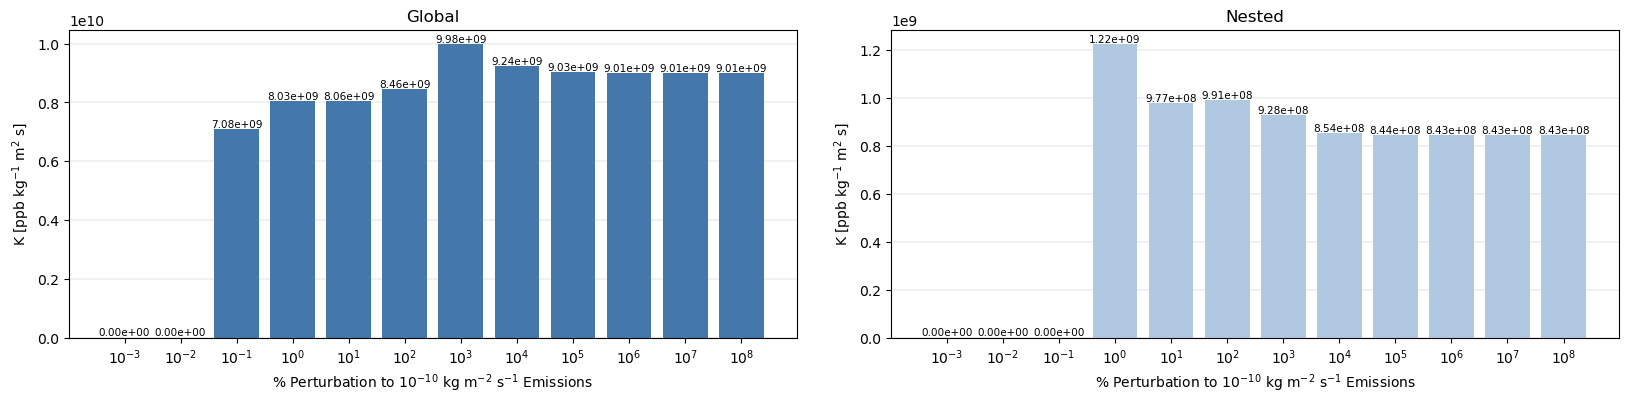

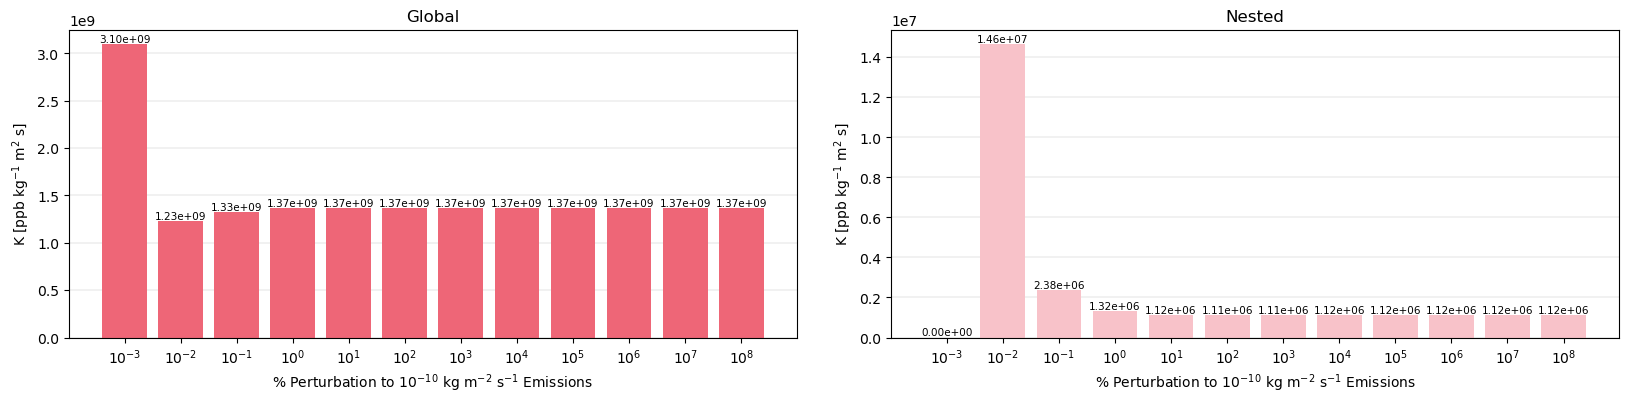

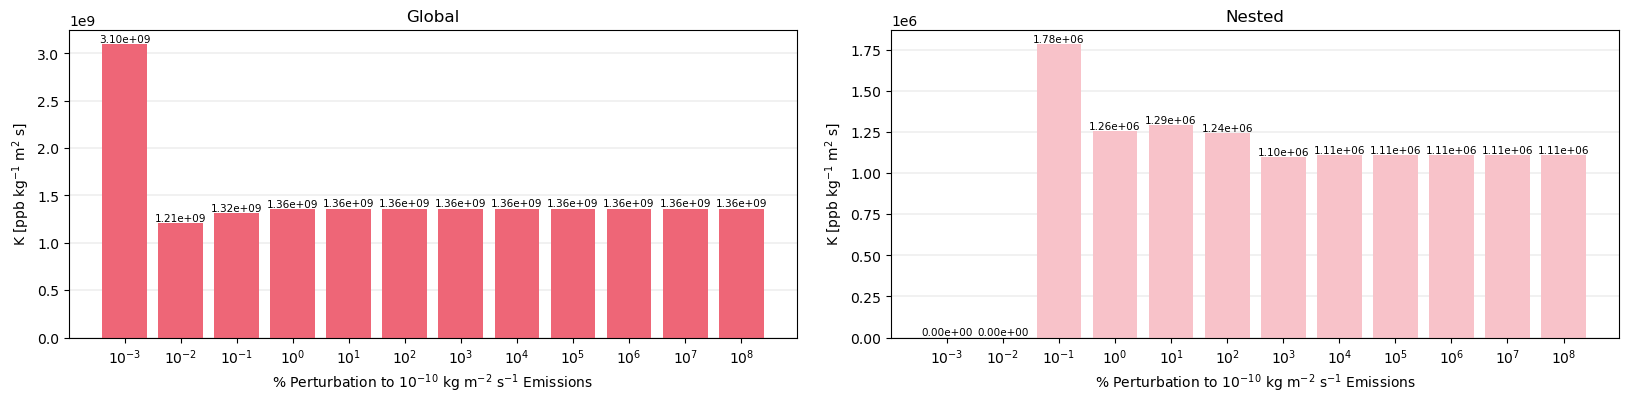

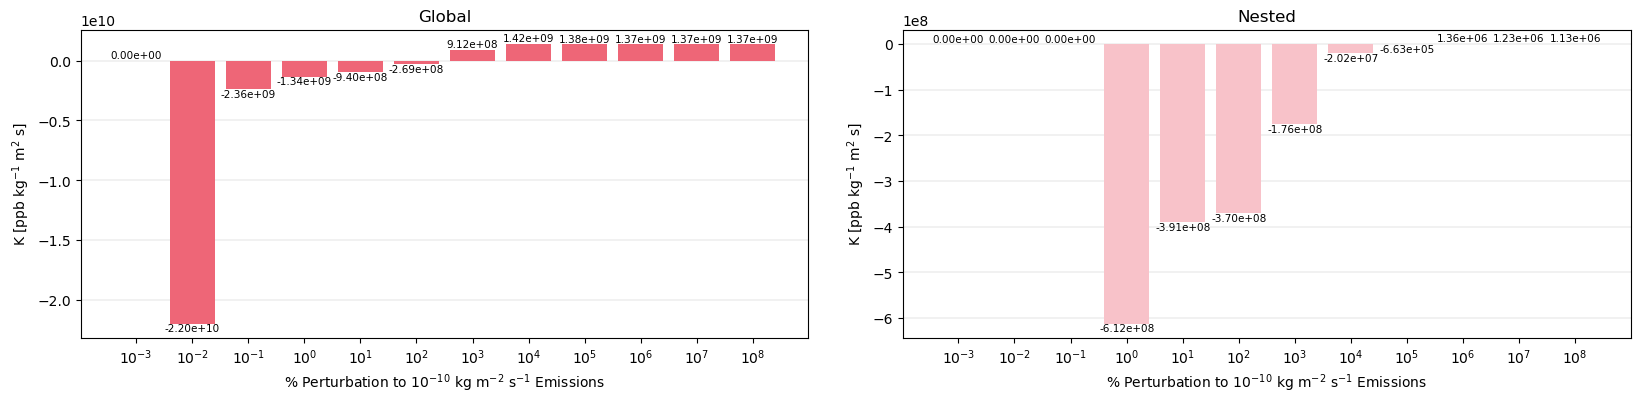

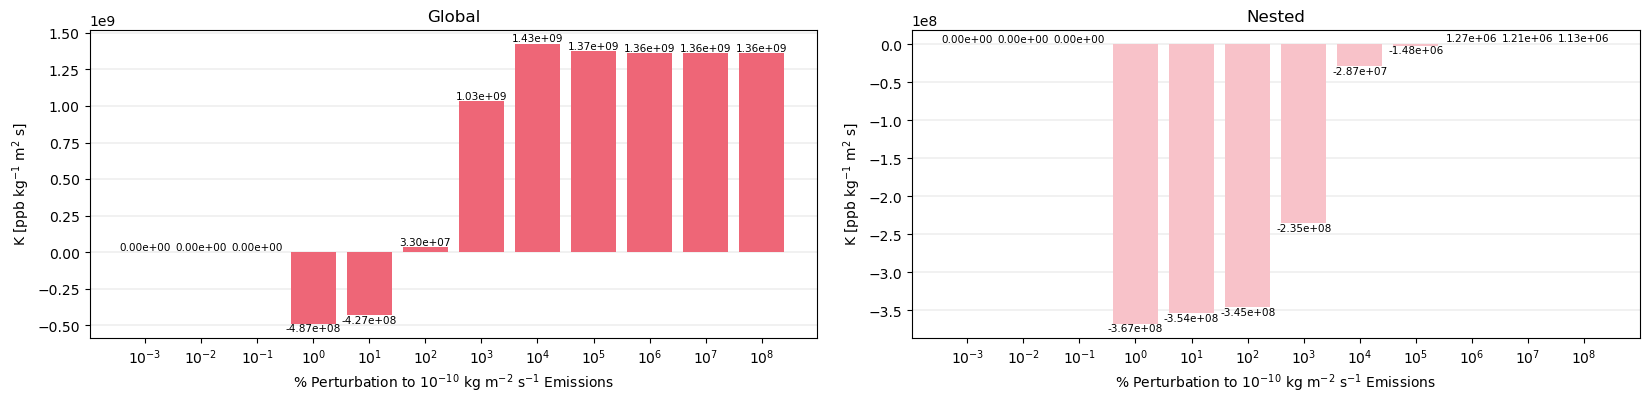

In [3]:
FIG = 1
for adj in [False, True]:
    for scenario in ["1", "2", "3", "4"]:
        fig,axs = plt.subplots(1,2,figsize=(20,4))
        for idx,domain in enumerate(["global", "nested"]):
            k = []
            perts = ["10$^{-3}$", "10$^{-2}$", "10$^{-1}$", "10$^{0}$", "10$^{1}$", "10$^{2}$", "10$^{3}$", "10$^{4}$", "10$^{5}$", "10$^{6}$", "10$^{7}$", "10$^{8}$"]
            for idy in range(len(perts)):
                k.append(calc_k(domain, scenario, idy, adj))
            print()

            if idx == 0 and not adj:
                color = "#4477aa"
            elif idx == 1 and not adj:
                color = "#b1c9e0"
            elif idx == 0 and adj:
                color = "#ee6677"
            elif idx == 1 and adj:
                color = "#f8c2c9"
                
            axs[idx].bar(perts, k, color=color)
            axs[idx].set_ylabel("K [ppb kg$^{-1}$ m$^{2}$ s]")
            axs[idx].set_xlabel("% Perturbation to 10$^{-10}$ kg m$^{-2}$ s$^{-1}$ Emissions")
            for i, v in enumerate(k):
                if v >= 0:
                    va = "bottom"
                else:
                    va = "top"
                axs[idx].text(i, v, f'{v:.2e}', ha="center", va=va, fontsize=7.5)

            if idx == 0:
                axs[idx].set_title("Global")
            else:
                axs[idx].set_title("Nested")
            
            axs[idx].grid(axis="y", linewidth=0.25)
            axs[idx].set_axisbelow(True)
            
        fig.subplots_adjust(wspace=0.13)
        fig.savefig(f"figure-{FIG}.pdf", bbox_inches="tight")
        FIG += 1